**Loading in an ensemble of trajectories**

In [1]:
import pyqofta as pqt
import numpy as np
import os
from natsort import natsorted
import matplotlib.pyplot as plt

traj_parent_dir = '/users/kyleacheson/CHD_TRAJS/'
traj_paths = natsorted([traj_parent_dir+fpath for fpath in os.listdir(traj_parent_dir) if 'xyz' in fpath])# list and sort all files numerically
ensemble = pqt.Ensemble.load_ensemble(traj_paths, 'sh')
dt = 0.1 # wrong time is stored in xyz files

In [2]:
average_trajectory = ensemble.average_()

**Define  distance function to broadcast over ensemble**

In [4]:
def get_distance(traj, connectivity):
    traj_bond_len = np.array(list(traj.broadcast(pqt.Molecule.bond_length, connectivity)))
    return traj_bond_len

c1_c6 = [0, 5]
distances_map = ensemble.broadcast(get_distance, c1_c6)
distances = np.array(list(distances_map))

**Plot all C1-C6 distances**

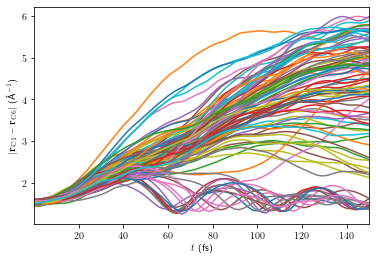

In [5]:
plt.rcParams['text.usetex'] = True
plt.plot(np.array(ensemble.trajs[0].time)*dt, np.transpose(distances))
plt.xlabel('$t$ (fs)')
plt.ylabel('$|\mathbf{r}_{\mathrm{C1}} - \mathbf{r}_{\mathrm{C6}}|$ (\AA$^{-1}$)')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

**Scattering examples**

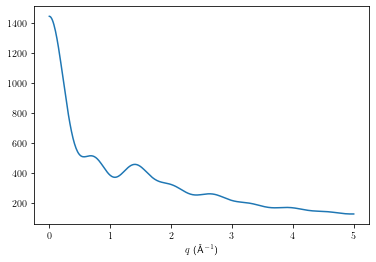

In [106]:
cs2_mol_path = '../data/Molecules/cs2.xyz'                                         
cs2 = pqt.Molecule.init_from_xyz(cs2_mol_path)                                     
                                                                                   
qmax, Nq = 5, 400 # DEFINE MOMENTUM TRANSFER VECTOR                                
qvec = np.linspace(0, qmax, Nq)                                                    
                                                                                   
[FF, fq] = pqt.IAM_form_factors(cs2, qvec) # GET FORM FACTORS FOR MOLECULE - ONLY NEED TO DO ONCE
I_xray = pqt.IAM_molecular_scattering(cs2, qvec, fq, FF)                          
                                                                                
fig = plt.figure() 
plt.rcParams['text.usetex'] = True
plt.plot(qvec, I_xray) # PLOT OF STATIC CS2 XRS SIGNAL
plt.xlabel('$q$ (\AA$^{-1}$)')
plt.show()

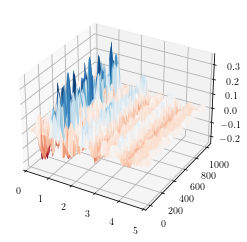

In [109]:
traj_parent_dir = '../data/Trajectories/CS2/bound/'                                
trj_type = 'sh'                                                                    
traj_paths = [subdir.path + '/output.xyz' for subdir in os.scandir(traj_parent_dir) if subdir.is_dir()] # LIST OF ALL TRAJ PATHS
sh_ensemble = pqt.Ensemble(traj_paths, trj_type) # INIT AN ENSEMBLE OBJECT CONTAINING TRAJS ETC.
                                                                                   
# FOR AN EXAMPLE WE NOW TAKE ONE TRAJ OUT OF THE ENSEMBLE                          
trajectory = sh_ensemble.trajs[0]                                                  
Itrj = pqt.IAM_trajectory_scattering(trajectory, qvec, fq, FF) # SINGLE TRAJ SCATTERING
                                                                                   
pdw = np.zeros((trajectory.nts, Nq))                                               
for i in range(trajectory.nts):                                                    
    pdw[i, :] = (Itrj[i, :] - Itrj[0, :])/Itrj[0, :] # CALCULATE PERCENTAGE DIFFERENCE SIGNAL (Ion-Ioff / Ioff)
                                                                                   
[Q, T] = np.meshgrid(qvec, trajectory.time)                                        
fig = plt.figure()                                                                 
ax = plt.axes(projection='3d')                                                     
ax.plot_surface(Q, T, pdw, edgecolor='none', cmap='RdBu') # SINGLE TRAJECTORY SIGNAL PLOT
plt.xlim([0, 5])                                                                                                                                                                                
plt.show()   

**Load clustering modules**

In [98]:
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from scipy.cluster.hierarchy import dendrogram, linkage

In [99]:
def cluster_generator(number_clusters: int, link_type: str):
    while number_clusters > 0:
        yield AgglomerativeClustering(n_clusters=number_clusters, affinity='euclidean', compute_distances=True, linkage=link_type)
        #yield FeatureAgglomeration(n_clusters=number_clusters, affinity='euclidean', linkage=link_type)
        number_clusters -= 1

In [100]:
cluster_models = cluster_generator(5, 'single')
data = distances[:, -1]

for cluster_model in cluster_models:
    cluster_model.fit(data.reshape(-1, 1))

In [ ]:
fit_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', compute_distances=True, linkage='single')
fit_cluster.fit(data.reshape(-1, 1))

In [101]:
import itertools
ii = itertools.count(data.shape[0])
clusters = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in fit_cluster.children_]

import copy
n_points = data.shape[0]
members = {i:[i] for i in range(n_points)}
for cluster in clusters:
    node_id = cluster["node_id"]
    members[node_id] = copy.deepcopy(members[cluster["left"]])
    members[node_id].extend(copy.deepcopy(members[cluster["right"]]))

on_split = {c["node_id"]: [c["left"], c["right"]] for c in clusters}
up_merge = {c["left"]: {"into": c["node_id"], "with": c["right"]} for c in clusters}
up_merge.update({c["right"]: {"into": c["node_id"], "with": c["left"]} for c in clusters})

In [93]:
def linkage_mat(model):                                                                          
    # Create linkage matrix and then plot the dendrogram                        
                                                                                                               
    # create the counts of samples under each node                              
    counts = np.zeros(model.children_.shape[0])                                                                
    n_samples = len(model.labels_)                                                                             
    for i, merge in enumerate(model.children_):                                                                
        current_count = 0                                                                                      
        for child_idx in merge:                                                                                
            if child_idx < n_samples:                                                                          
                current_count += 1  # leaf node                                                                
            else:                                                                                              
                current_count += counts[child_idx - n_samples]                  
        counts[i] = current_count                                                                              
                                                                                                               
    linkage_matrix = np.column_stack(                                                                          
        [model.children_, model.distances_, counts]                             
    ).astype(float)                                                                                            
                                                                                                                                                                                                                                                            
    return linkage_matrix   

In [94]:
dmodel = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
dmodel.fit(data.reshape(-1, 1))

AgglomerativeClustering(distance_threshold=0, linkage='single', n_clusters=None)

In [95]:
links = linkage_mat(dmodel)

In [96]:
def plot_dendrogram(model, **kwargs):                                              
    # Create linkage matrix and then plot the dendrogram                           
                                                                                   
    # create the counts of samples under each node                                 
    counts = np.zeros(model.children_.shape[0])                                    
    n_samples = len(model.labels_)                                                 
    for i, merge in enumerate(model.children_):                                    
        current_count = 0                                                          
        for child_idx in merge:                                                    
            if child_idx < n_samples:                                              
                current_count += 1  # leaf node                                    
            else:                                                                  
                current_count += counts[child_idx - n_samples]                     
        counts[i] = current_count                                                  
                                                                                   
    linkage_matrix = np.column_stack(                                              
        [model.children_, model.distances_, counts]                                
    ).astype(float)                                                                
                                                                                   
    # Plot the corresponding dendrogram  
    plt.figure(figsize=(25,25))
    dendrogram(linkage_matrix, **kwargs)
    plt.xticks(fontsize=20)
    #plt.savefig('chd_dendrogram.png')
    plt.show() 

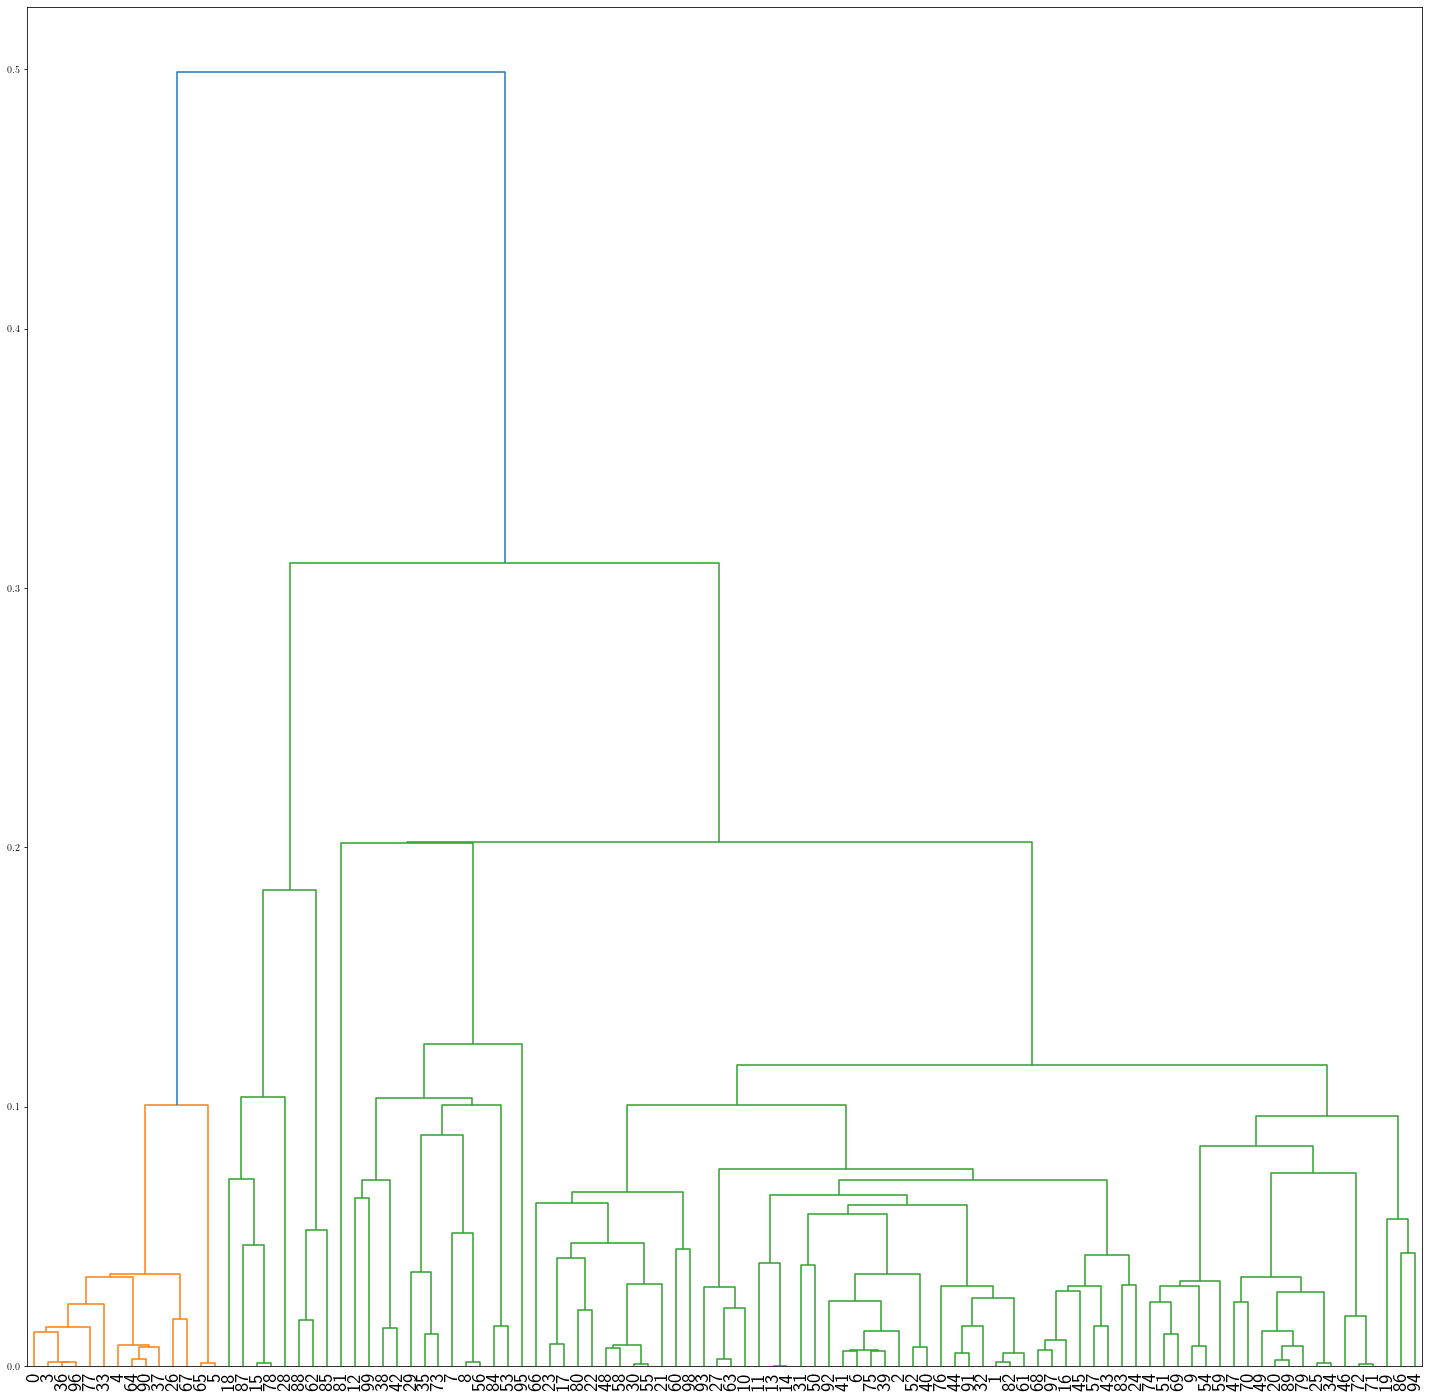

In [97]:
plot_dendrogram(dmodel)